In [1]:
import composeml as cp
import featuretools as ft
import pandas as pd
import data

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
df = data.load('data/train_FD004.txt')
df[df.columns[:7]].head()

,engine_no,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_1,sensor_measurement_2
0,1,1,42.0049,0.8400,100.0,445.00,549.68
1,1,2,20.0020,0.7002,100.0,491.19,606.07
2,1,3,42.0038,0.8409,100.0,445.00,548.95
3,1,4,42.0000,0.8400,100.0,445.00,548.70
4,1,5,25.0063,0.6207,60.0,462.54,536.10


In [3]:
def remaining_useful_life(df):
    return len(df) - 1

In [4]:
lm = cp.LabelMaker(
    target_entity='engine_no',
    time_index='time',
    labeling_function=remaining_useful_life,
)

In [5]:
lt = lm.search(
    df.sort_values('time'),
    num_examples_per_instance=10,
    minimum_data=100,
    gap=1,
    verbose=True,
)

lt.head()

Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| engine_no: 2490/2490 


,engine_no,cutoff_time,remaining_useful_life
id,,,
0,1,2000-01-01 16:40:00,220
1,1,2000-01-01 16:50:00,219
2,1,2000-01-01 17:00:00,218
3,1,2000-01-01 17:10:00,217
4,1,2000-01-01 17:20:00,216


In [6]:
lt.describe()

Settings
--------
label_type                              continuous
labeling_function            remaining_useful_life
num_examples_per_instance                       10
minimum_data                                   100
window_size                                  61249
gap                                              1


Transforms
----------
No transforms applied



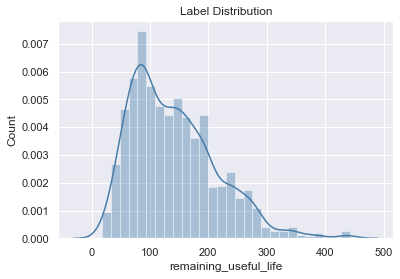

In [7]:
lt.plot.distribution();

In [8]:
lt = lt.bin(4, quantiles=True)

In [9]:
lt.describe()

Label Distribution
------------------
(128.0, 187.0]     629
(17.999, 83.0]     625
(83.0, 128.0]      622
(187.0, 442.0]     614
Total:            2490


Settings
--------
label_type                                discrete
labeling_function            remaining_useful_life
num_examples_per_instance                       10
minimum_data                                   100
window_size                                  61249
gap                                              1


Transforms
----------
1. bin
  - bins:            4
  - quantiles:    True
  - labels:       None
  - right:        True



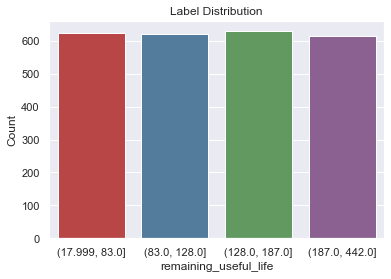

In [10]:
lt.plot.distribution();

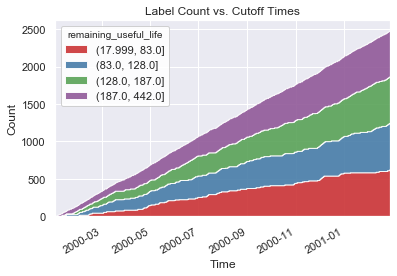

In [11]:
lt.plot.count_by_time();

In [12]:
es = ft.EntitySet('observations')

es.entity_from_dataframe(
    dataframe=df,
    entity_id='recordings',
    index='id',
    time_index='time',
    make_index=True,
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='engines',
    index='engine_no',
)

es.normalize_entity(
    base_entity_id='recordings',
    new_entity_id='cycles',
    index='time_in_cycles',
)

Entityset: observations
  Entities:
    recordings [Rows: 61249, Columns: 28]
    engines [Rows: 249, Columns: 2]
    cycles [Rows: 543, Columns: 2]
  Relationships:
    recordings.engine_no -> engines.engine_no
    recordings.time_in_cycles -> cycles.time_in_cycles

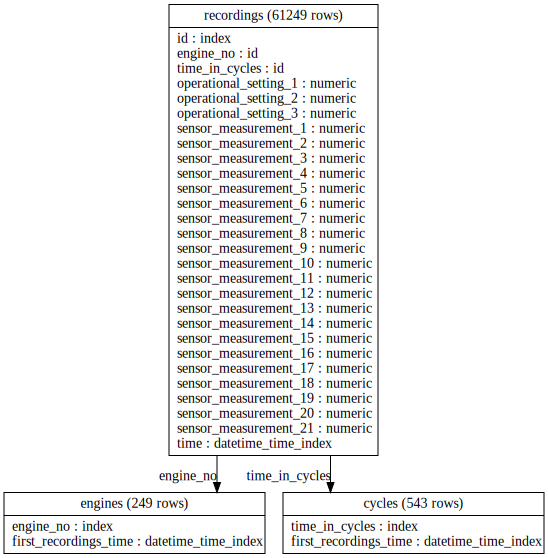

In [13]:
es.plot()

In [14]:
lt = lt.sample(frac=.2, random_state=0)

In [15]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='engines',
    agg_primitives=['last', 'max', 'min'],
    trans_primitives=[],
    cutoff_time=lt,
    cutoff_time_in_index=True,
    max_depth=3,
    verbose=True,
)

fm.head()

Built 292 features
Elapsed: 08:17 | Progress: 100%|█████████████████████████████████████████████████████████████████████| Remaining: 00:00


LAST(recordings.id)  \
engine_no time                                       
1         2000-01-01 16:50:00                  101   
          2000-01-01 18:10:00                  109   
2         2000-01-03 22:10:00                  421   
          2000-01-03 22:50:00                  425   
          2000-01-03 23:20:00                  428   

                               LAST(recordings.time_in_cycles)  \
engine_no time                                                   
1         2000-01-01 16:50:00                              102   
          2000-01-01 18:10:00                              110   
2         2000-01-03 22:10:00                              101   
          2000-01-03 22:50:00                              105   
          2000-01-03 23:20:00                              108   

                               LAST(recordings.operational_setting_1)  \
engine_no time                                                          
1         2000-01-01 16:50:00                                 42.0057   
          2000-01-01 18:10:00                                 25.0070   
2         2000-01-03 22:10:00                                 34.9989   
          2000-01-03 22:50:00                                 42.0015   
          2000-01-03 23:20:00                                 20.0061   

                               LAST(recordings.operational_setting_2)  \
engine_no time                                                          
1         2000-01-01 16:50:00                                  0.8400   
          2000-01-01 18:10:00                                  0.6200   
2         2000-01-03 22:10:00                                  0.8402   
          2000-01-03 22:50:00                                  0.8400   
          2000-01-03 23:20:00                                  0.7015   

                               LAST(recordings.operational_setting_3)  \
engine_no time                                                          
1         2000-01-01 16:50:00                                   100.0   
          2000-01-01 18:10:00                                    60.0   
2         2000-01-03 22:10:00                                   100.0   
          2000-01-03 22:50:00                                   100.0   
          2000-01-03 23:20:00                                   100.0   

                               LAST(recordings.sensor_measurement_1)  \
engine_no time                                                         
1         2000-01-01 16:50:00                                 445.00   
          2000-01-01 18:10:00                                 462.54   
2         2000-01-03 22:10:00                                 449.44   
          2000-01-03 22:50:00                                 445.00   
          2000-01-03 23:20:00                                 491.19   

                               LAST(recordings.sensor_measurement_2)  \
engine_no time                                                         
1         2000-01-01 16:50:00                                 549.11   
          2000-01-01 18:10:00                                 535.85   
2         2000-01-03 22:10:00                                 555.49   
          2000-01-03 22:50:00                                 549.47   
          2000-01-03 23:20:00                                 607.45   

                               LAST(recordings.sensor_measurement_3)  \
engine_no time                                                         
1         2000-01-01 16:50:00                                1341.25   
          2000-01-01 18:10:00                                1255.17   
2         2000-01-03 22:10:00                                1359.56   
          2000-01-03 22:50:00                                1349.80   
          2000-01-03 23:20:00                                1478.40   

                               LAST(recordings.sensor_measurement_4)  \
engine_no time                                                    

In [16]:
y = fm.pop(lt.name)
y = y.astype('str')

x = fm.fillna(0)
x, fe = ft.encode_features(x, fd)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size=.8,
    test_size=.2,
    random_state=0,
)

In [18]:
clf = RandomForestClassifier(n_estimators=10, random_state=0)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
y_hat = clf.predict(x_test)
print(classification_report(y_test, y_hat))

                precision    recall  f1-score   support

(128.0, 187.0]       0.73      0.68      0.70        28
(17.999, 83.0]       0.62      0.80      0.70        25
(187.0, 442.0]       0.88      0.81      0.84        26
 (83.0, 128.0]       0.67      0.57      0.62        21

      accuracy                           0.72       100
     macro avg       0.72      0.71      0.72       100
  weighted avg       0.73      0.72      0.72       100



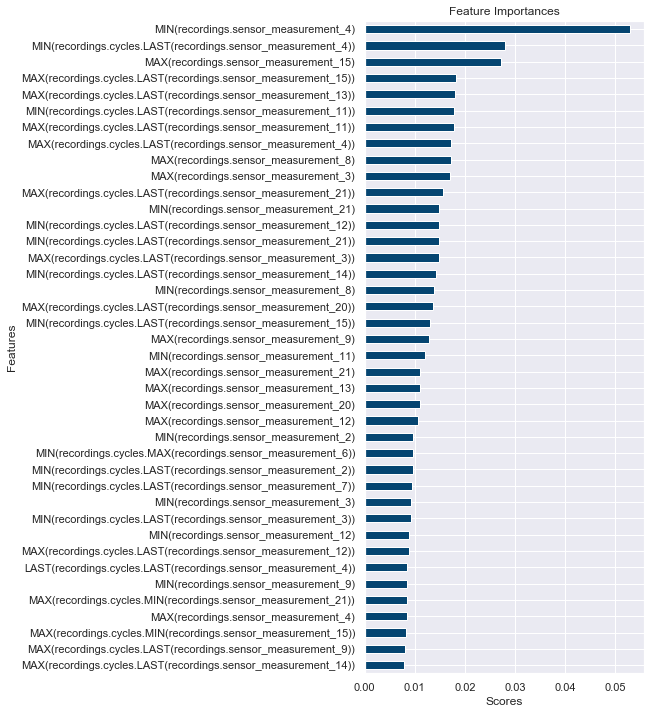

In [20]:
feature_importances = zip(x_train.columns, clf.feature_importances_)
feature_importances = pd.Series(dict(feature_importances))
feature_importances = feature_importances.rename_axis('Features')
feature_importances = feature_importances.sort_values()

top_features = feature_importances.tail(40)
plot = top_features.plot(kind='barh', figsize=(5, 12), color='#054571')
plot.set_title('Feature Importances')
plot.set_xlabel('Scores');